In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [81]:
movies = pd.read_csv('movies_cleaned.csv').select_dtypes(exclude=object)
cats = pd.read_csv('movies_cat.csv')

In [82]:
countries = pd.get_dummies(cats['Country']).drop('Other', axis=1)
genres = cats['Genres'].str.get_dummies(', ')
mpaa = pd.get_dummies(cats['MPAA']).drop('OTHER', axis=1)
prodco = cats['ProdCo'].str.get_dummies(', ').drop('Other', axis=1)
stars = cats['Stars'].str.get_dummies(', ').drop('Other', axis=1)
month = pd.get_dummies(movies['ReleaseMonth'])
year = pd.get_dummies(movies['ReleaseYear']).drop([2018.0, 1991.0], axis=1, inplace=True)
comps = pd.get_dummies(movies['Comps']).drop([58.0, 61.0, 22.0, 23.0, 68.0, 72.0, 16.0], axis=1, inplace=True)

In [83]:
y = movies['IMDBRating']
movies = movies[(movies['IMDBRating'] < (y.mean() + 2 * y.std()))
                & (movies['IMDBRating'] > (y.mean() - 2 * y.std()))]

In [84]:
columns = ['IMDBRatingCount', 'RunTime', 'UserCount', 'CriticCount', 'Metascore', 'Budget', 'Opening', 'GrossUSA', 'GrossIntl']
movies[['log{}'.format(i) for i in columns]] = movies[columns].apply(np.log)

In [85]:
movies.corr()

,IMDBRating,IMDBRatingCount,RunTime,UserCount,CriticCount,Metascore,Budget,Opening,GrossUSA,GrossIntl,...,Comps,logIMDBRatingCount,logRunTime,logUserCount,logCriticCount,logMetascore,logBudget,logOpening,logGrossUSA,logGrossIntl
IMDBRating,1.000000,0.555649,0.401402,0.331811,0.377228,0.727563,0.009791,0.017739,0.178587,0.195377,...,0.016538,0.516111,0.400083,0.363718,0.363212,0.715666,-0.077041,-0.253335,0.025171,0.114391
IMDBRatingCount,0.555649,1.000000,0.332605,0.716729,0.588616,0.380402,0.376578,0.473854,0.594863,0.579695,...,-0.074502,0.825792,0.323121,0.695257,0.535406,0.361885,0.284038,0.262138,0.423985,0.501910
RunTime,0.401402,0.332605,1.000000,0.348222,0.239868,0.252467,0.276850,0.140402,0.197368,0.235428,...,-0.048488,0.299650,0.993973,0.349644,0.198645,0.256769,0.260649,-0.023521,0.095794,0.181671
UserCount,0.331811,0.716729,0.348222,1.000000,0.525360,0.256139,0.378726,0.458986,0.528880,0.497792,...,-0.061468,0.638912,0.336837,0.846006,0.487540,0.242620,0.242424,0.249085,0.372508,0.399248
CriticCount,0.377228,0.588616,0.239868,0.525360,1.000000,0.404512,0.347822,0.410922,0.403926,0.443218,...,0.044229,0.612339,0.243203,0.577057,0.931210,0.377425,0.183583,0.152355,0.272748,0.353564
Metascore,0.727563,0.380402,0.252467,0.256139,0.404512,1.000000,-0.041735,0.003219,0.159079,0.150229,...,0.010270,0.343038,0.249886,0.266518,0.369950,0.980271,-0.154736,-0.269045,0.028678,0.066973
Budget,0.009791,0.376578,0.276850,0.378726,0.347822,-0.041735,1.000000,0.674273,0.634043,0.687367,...,-0.157127,0.398269,0.268460,0.374077,0.317371,-0.020590,0.827075,0.513119,0.486810,0.604158
Opening,0.017739,0.473854,0.140402,0.458986,0.410922,0.003219,0.674273,1.000000,0.866069,0.816383,...,-0.104209,0.454524,0.136008,0.413028,0.351818,0.021747,0.528001,0.631008,0.573862,0.627750
GrossUSA,0.178587,0.594863,0.197368,0.528880,0.403926,0.159079,0.634043,0.866069,1.000000,0.921437,...,-0.153711,0.546564,0.187082,0.468784,0.337125,0.165529,0.511051,0.542795,0.661112,0.710251
GrossIntl,0.195377,0.579695,0.235428,0.497792,0.443218,0.150229,0.687367,0.816383,0.921437,1.000000,...,-0.120262,0.520424,0.221828,0.431576,0.375702,0.156081,0.521094,0.464403,0.556789,0.712090


In [86]:
y = movies['IMDBRating']
X = movies.drop('IMDBRating', axis=1)

In [87]:
X.columns

Index(['IMDBRatingCount', 'RunTime', 'UserCount', 'CriticCount', 'Metascore',
       'Budget', 'Opening', 'GrossUSA', 'GrossIntl', 'Awards', 'Noms', 'Wins',
       'ActNoms', 'ActWins', 'ActAwards', 'ActCreds', 'ReleaseMonth',
       'ReleaseYear', 'Comps', 'logIMDBRatingCount', 'logRunTime',
       'logUserCount', 'logCriticCount', 'logMetascore', 'logBudget',
       'logOpening', 'logGrossUSA', 'logGrossIntl'],
      dtype='object')

In [88]:
choices = [countries, genres, mpaa, prodco, stars, month, year, comps]

In [89]:
cols = ['logIMDBRatingCount', 'RunTime', 'logUserCount', 'logOpening', 'CriticCount']
cates = [genres.drop(['Crime', 'Family', 'History', 'Music', 'Musical', 'Sport',
                      'Thriller', 'War', 'Western'], axis=1),
         countries.drop(['Australia', 'France', 'Germany', 'Italy', 'Japan', 'Spain'], axis=1)]

In [90]:
for i in cates:
    Xs = X[cols].join(cates)

In [91]:
#LassoCV
Xtrv, Xte, ytrv, yte = train_test_split(Xs, y, test_size=0.2)
Xtr, Xv, ytr, yv = train_test_split(Xtrv, ytrv, test_size=0.25)

In [92]:
std = StandardScaler()
Xtr = std.fit_transform(Xtr)
Xv = std.transform(Xv)
Xte = std.transform(Xte)

In [93]:
alphas = [10 ** i for i in range(-10, 10)]
lcv = LassoCV(alphas=alphas, cv=5)
lcv.fit(Xtr, ytr)
ypred = lcv.predict(Xv)
list(zip(Xs.columns, lcv.coef_))

[('logIMDBRatingCount', 0.6044300257379297),
 ('RunTime', 0.16078938075229438),
 ('logUserCount', -0.07472080024345014),
 ('logOpening', -0.29512781223915496),
 ('CriticCount', 0.027838490101168126),
 ('Action', -0.07816713715047935),
 ('Adventure', -0.03198951478869101),
 ('Animation', 0.20671972535410887),
 ('Biography', 0.03478614690464266),
 ('Comedy', -0.020646481249616808),
 ('Drama', 0.11897117903293233),
 ('Fantasy', -0.06852988105272614),
 ('Horror', -0.08143682133886812),
 ('Mystery', 0.012496623305635932),
 ('Romance', -0.04506159739710714),
 ('Sci-Fi', -0.04881757583486169),
 ('Canada', -0.028272870623008383),
 ('China', 0.03803757570858867),
 ('Hong Kong', 0.0015317269555292165),
 ('UK', 0.005970575489416546),
 ('USA', -0.0574774524165333)]

In [94]:
lcv.score(Xv, yv), np.sqrt(mean_squared_error(yv, ypred)), lcv.alpha_

(0.6102948776386832, 0.5050693700401361, 0.001)

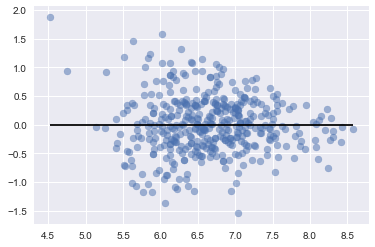

In [95]:
plt.scatter(ypred, yv - ypred, alpha=0.5)
plt.hlines(0, np.min(ypred), np.max(ypred));

In [96]:
ypred = lcv.predict(Xte)
lcv.score(Xte, yte), np.sqrt(mean_squared_error(yte, ypred))

(0.6703276774778393, 0.4986645691337684)

In [97]:
#RidgeCV
Xtrv, Xte, ytrv, yte = train_test_split(Xs, y, test_size=0.2)
Xtr, Xv, ytr, yv = train_test_split(Xtrv, ytrv, test_size=0.25)

In [98]:
std = StandardScaler()
Xtr = std.fit_transform(Xtr)
Xv = std.transform(Xv)
Xte = std.transform(Xte)

In [99]:
alphas = [10 ** i for i in range(-10, 10)]
rcv = RidgeCV(alphas=alphas, cv=5)
rcv.fit(Xtr, ytr)
ypred = rcv.predict(Xv)
list(zip(Xs.columns, lcv.coef_))

[('logIMDBRatingCount', 0.6044300257379297),
 ('RunTime', 0.16078938075229438),
 ('logUserCount', -0.07472080024345014),
 ('logOpening', -0.29512781223915496),
 ('CriticCount', 0.027838490101168126),
 ('Action', -0.07816713715047935),
 ('Adventure', -0.03198951478869101),
 ('Animation', 0.20671972535410887),
 ('Biography', 0.03478614690464266),
 ('Comedy', -0.020646481249616808),
 ('Drama', 0.11897117903293233),
 ('Fantasy', -0.06852988105272614),
 ('Horror', -0.08143682133886812),
 ('Mystery', 0.012496623305635932),
 ('Romance', -0.04506159739710714),
 ('Sci-Fi', -0.04881757583486169),
 ('Canada', -0.028272870623008383),
 ('China', 0.03803757570858867),
 ('Hong Kong', 0.0015317269555292165),
 ('UK', 0.005970575489416546),
 ('USA', -0.0574774524165333)]

In [100]:
rcv.score(Xv, yv), np.sqrt(mean_squared_error(yv, ypred)), rcv.alpha_

(0.6820311464031703, 0.46746077097090033, 10)

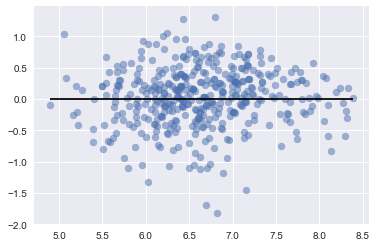

In [101]:
plt.scatter(ypred, yv - ypred, alpha=0.5)
plt.hlines(0, np.min(ypred), np.max(ypred));

In [102]:
ypred = rcv.predict(Xte)
lcv.score(Xte, yte), np.sqrt(mean_squared_error(yte, ypred))

(0.6403251612540923, 0.49359740704964516)

In [103]:
#ElasticNetCV
Xtrv, Xte, ytrv, yte = train_test_split(Xs, y, test_size=0.2)
Xtr, Xv, ytr, yv = train_test_split(Xtrv, ytrv, test_size=0.25)

In [104]:
std = StandardScaler()
Xtr = std.fit_transform(Xtr)
Xv = std.transform(Xv)
Xte = std.transform(Xte)

In [105]:
alphas = [10 ** i for i in range(-10, 10)]
encv = ElasticNetCV(alphas=alphas, cv=5)
encv.fit(Xtr, ytr)
ypred = encv.predict(Xv)
list(zip(Xs.columns, lcv.coef_))

[('logIMDBRatingCount', 0.6044300257379297),
 ('RunTime', 0.16078938075229438),
 ('logUserCount', -0.07472080024345014),
 ('logOpening', -0.29512781223915496),
 ('CriticCount', 0.027838490101168126),
 ('Action', -0.07816713715047935),
 ('Adventure', -0.03198951478869101),
 ('Animation', 0.20671972535410887),
 ('Biography', 0.03478614690464266),
 ('Comedy', -0.020646481249616808),
 ('Drama', 0.11897117903293233),
 ('Fantasy', -0.06852988105272614),
 ('Horror', -0.08143682133886812),
 ('Mystery', 0.012496623305635932),
 ('Romance', -0.04506159739710714),
 ('Sci-Fi', -0.04881757583486169),
 ('Canada', -0.028272870623008383),
 ('China', 0.03803757570858867),
 ('Hong Kong', 0.0015317269555292165),
 ('UK', 0.005970575489416546),
 ('USA', -0.0574774524165333)]

In [106]:
encv.score(Xv, yv), np.sqrt(mean_squared_error(yv, ypred)), encv.alpha_

(0.6055842572332881, 0.5374343699131883, 0.001)

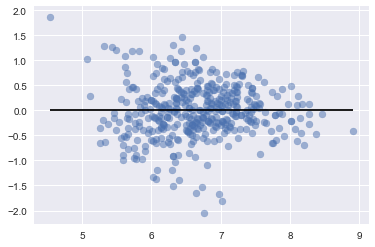

In [107]:
plt.scatter(ypred, yv - ypred, alpha=0.5)
plt.hlines(0, np.min(ypred), np.max(ypred));

In [108]:
ypred = encv.predict(Xte)
lcv.score(Xte, yte), np.sqrt(mean_squared_error(yte, ypred))

(0.6935916555320156, 0.4772999179504351)

In [109]:
#Linear regression
Xtrv, Xte, ytrv, yte = train_test_split(Xs, y, test_size=0.2)
Xtr, Xv, ytr, yv = train_test_split(Xtrv, ytrv, test_size=0.25)

In [110]:
lr = LinearRegression()
lr.fit(Xtr, ytr)
ypred = lr.predict(Xv)
list(zip(Xs.columns, lcv.coef_))

[('logIMDBRatingCount', 0.6044300257379297),
 ('RunTime', 0.16078938075229438),
 ('logUserCount', -0.07472080024345014),
 ('logOpening', -0.29512781223915496),
 ('CriticCount', 0.027838490101168126),
 ('Action', -0.07816713715047935),
 ('Adventure', -0.03198951478869101),
 ('Animation', 0.20671972535410887),
 ('Biography', 0.03478614690464266),
 ('Comedy', -0.020646481249616808),
 ('Drama', 0.11897117903293233),
 ('Fantasy', -0.06852988105272614),
 ('Horror', -0.08143682133886812),
 ('Mystery', 0.012496623305635932),
 ('Romance', -0.04506159739710714),
 ('Sci-Fi', -0.04881757583486169),
 ('Canada', -0.028272870623008383),
 ('China', 0.03803757570858867),
 ('Hong Kong', 0.0015317269555292165),
 ('UK', 0.005970575489416546),
 ('USA', -0.0574774524165333)]

In [111]:
lr.score(Xv, yv), np.sqrt(mean_squared_error(yv, ypred))

(0.6702185676325463, 0.47957651854505473)

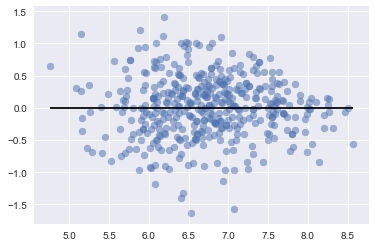

In [112]:
plt.scatter(ypred, yv - ypred, alpha=0.5)
plt.hlines(0, np.min(ypred), np.max(ypred));

In [113]:
ypred = lr.predict(Xte)
lr.score(Xte, yte), np.sqrt(mean_squared_error(yte, ypred))

(0.6406121423453215, 0.5287407155524271)

In [114]:
#Feature engineering
Xtrv, Xte, ytrv, yte = train_test_split(Xs, y, test_size=0.2)
Xtr, Xv, ytr, yv = train_test_split(Xtrv, ytrv, test_size=0.25)

In [115]:
std = StandardScaler()
Xtr = std.fit_transform(Xtr)
Xv = std.transform(Xv)
Xte = std.transform(Xte)

In [116]:
pf = PolynomialFeatures()
Xtr = pf.fit_transform(Xtr)
Xv = pf.transform(Xv)

In [117]:
alphas = [10 ** i for i in range(-5, 0)]
lcv = LassoCV(alphas=alphas, cv=5)
lcv.fit(Xtr, ytr)
ypred = lcv.predict(Xv)

/Users/lkchemposer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [118]:
lcv.score(Xv, yv), np.sqrt(mean_squared_error(yv, ypred)), lcv.alpha_

(0.6974375166237932, 0.4721106116885637, 0.01)

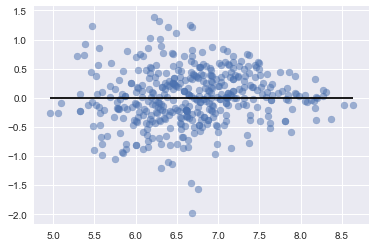

In [119]:
plt.scatter(ypred, yv - ypred, alpha=0.5)
plt.hlines(0, np.min(ypred), np.max(ypred));

In [120]:
feas = pd.DataFrame(list(zip(pf.get_feature_names(), lcv.coef_)))
feas.rename(columns={0: 'Features', 1: 'Coefs'}, inplace=True)
fnames = sorted(list(zip(['x{}'.format(i) for i in range(21)], Xs.columns)), reverse=True)
for i in range(len(fnames)):
    feas['Features'] = feas['Features'].str.replace(fnames[i][0], fnames[i][1])
feas['abs(Coefs)'] = abs(feas['Coefs'])
feas.sort_values('abs(Coefs)', ascending=False, inplace=True)
feas[feas['Features'].str.contains(' ')].head(20)

,Features,Coefs,abs(Coefs)
34,logIMDBRatingCount Horror,0.052428,0.052428
83,logOpening CriticCount,0.037322,0.037322
191,Drama Romance,-0.034758,0.034758
203,Fantasy Canada,-0.034755,0.034755
136,Adventure Comedy,0.033577,0.033577
44,RunTime logUserCount,-0.032704,0.032704
27,logIMDBRatingCount Action,0.032452,0.032452
25,logIMDBRatingCount logOpening,0.030817,0.030817
93,logOpening Romance,-0.030348,0.030348
119,Action Animation,0.029318,0.029318


In [121]:
feas[feas['Features'].str.contains('\^2')].head()

,Features,Coefs,abs(Coefs)
82,logOpening^2,-0.080001,0.080001
148,Animation^2,0.057952,0.057952
22,logIMDBRatingCount^2,0.056156,0.056156
252,USA^2,0.042472,0.042472
198,Fantasy^2,-0.021997,0.021997


In [122]:
feas.head(20)

,Features,Coefs,abs(Coefs)
1,logIMDBRatingCount,0.637165,0.637165
4,logOpening,-0.395478,0.395478
11,Drama,0.141794,0.141794
2,RunTime,0.134172,0.134172
82,logOpening^2,-0.080001,0.080001
148,Animation^2,0.057952,0.057952
22,logIMDBRatingCount^2,0.056156,0.056156
34,logIMDBRatingCount Horror,0.052428,0.052428
6,Action,-0.050993,0.050993
3,logUserCount,-0.048013,0.048013


In [123]:
#Add interaction terms (LassoCV)
cols = ['logMetascore', 'logIMDBRatingCount', 'RunTime', 'logUserCount', 'logOpening', 'CriticCount']
cates = [genres.drop(['Crime', 'Family', 'History', 'Music', 'Musical', 'Sport',
                      'Thriller', 'War', 'Western'], axis=1),
         countries.drop(['Australia', 'France', 'Germany', 'Italy', 'Japan', 'Spain'], axis=1)]

In [124]:
for i in cates:
    Xs = X[cols].join(cates)

In [125]:
Xs['logIMDBRatingCount * logUserCount'] = Xs['logIMDBRatingCount'] * Xs['logUserCount']
Xs.drop(['Hong Kong'], axis=1, inplace=True)

In [126]:
Xtrv, Xte, ytrv, yte = train_test_split(Xs, y, test_size=0.2)
Xtr, Xv, ytr, yv = train_test_split(Xtrv, ytrv, test_size=0.25)

In [127]:
std = StandardScaler()
Xtr = std.fit_transform(Xtr)
Xv = std.transform(Xv)
Xte = std.transform(Xte)

In [128]:
alphas = [10 ** i for i in range(-10, 1)]
lcv = LassoCV(alphas=alphas, cv=5, max_iter=100000)
lcv.fit(Xtr, ytr)
ypred = lcv.predict(Xv)
list(zip(Xs.columns, lcv.coef_))

[('logMetascore', 0.31256491390220803),
 ('logIMDBRatingCount', 0.06167941177920025),
 ('RunTime', 0.10687894076840326),
 ('logUserCount', -0.8519309144296886),
 ('logOpening', -0.1770460414444325),
 ('CriticCount', -0.06092388108984396),
 ('Action', -0.02473596431143883),
 ('Adventure', -0.037984288494581485),
 ('Animation', 0.12978402854928547),
 ('Biography', 0.03758873346387472),
 ('Comedy', -0.048924463375163874),
 ('Drama', 0.11377448984914881),
 ('Fantasy', -0.031835519252518964),
 ('Horror', -0.05041410250216454),
 ('Mystery', 0.018351405862741407),
 ('Romance', -0.015715784301231907),
 ('Sci-Fi', -0.028684941457745854),
 ('Canada', -0.01992024782251668),
 ('China', 0.012339774561911373),
 ('UK', 0.0026272046825680114),
 ('USA', -0.055753002238953735),
 ('logIMDBRatingCount * logUserCount', 1.143214541490081)]

In [129]:
lcv.score(Xv, yv), np.sqrt(mean_squared_error(yv, ypred)), lcv.alpha_

(0.7543398690359526, 0.44695948026839055, 0.0001)

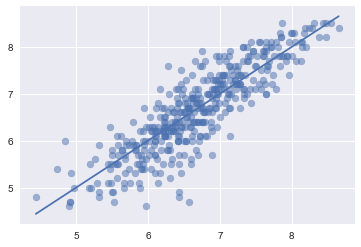

In [130]:
plt.scatter(ypred, yv, alpha=0.5)
plt.plot(np.linspace(np.min(ypred), np.max(ypred)), np.linspace(np.min(ypred), np.max(ypred)));

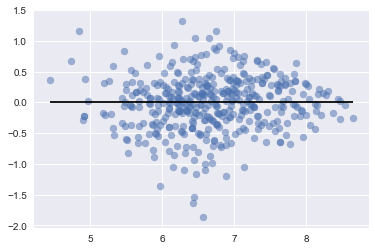

In [131]:
plt.scatter(ypred, yv - ypred, alpha=0.5)
plt.hlines(0, np.min(ypred), np.max(ypred));

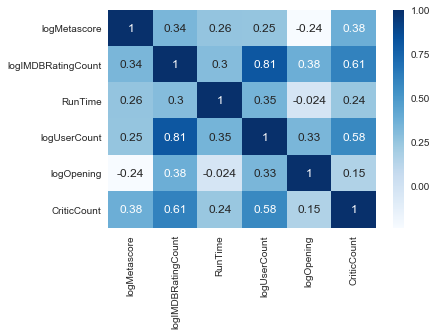

In [132]:
sns.heatmap(movies.corr().loc[cols, cols], annot=True, cmap='Blues');

In [133]:
ypred = lcv.predict(Xte)
lcv.score(Xte, yte), np.sqrt(mean_squared_error(yte, ypred))

(0.7319280070665312, 0.4191703982062734)

In [134]:
#Statsmodels
smXs = Xs.drop(['logIMDBRatingCount * logUserCount', 'RunTime', 'CriticCount', 'logUserCount', 'Adventure'], axis=1)

In [135]:
mod = sm.OLS(y, sm.add_constant(smXs))
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             IMDBRating   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     322.6
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        14:18:56   Log-Likelihood:                -1283.7
No. Observations:                2130   AIC:                             2603.
Df Residuals:                    2112   BIC:                             2705.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.7217      0.168     -4.300      0.000      -1.051      -0.392
logMetascore           1.0190      0.038     26.526      0.000       0.944       1.094
logIMDBRatingCount     0.4143      0.012     34.353      0.000       0.391       0.438
logOpening            -0.0867      0.006    -15.035      0.000      -0.098      -0.075
Action                -0.0771      0.026     -2.946      0.003      -0.129      -0.026
Animation              0.3795      0.040      9.512      0.000       0.301       0.458
Biography              0.1457      0.041      3.563      0.000       0.066       0.226
Comedy                -0.1453      0.025     -5.813      0.000      -0.194      -0.096
Drama                  0.2290      0.026      8.969      0.000       0.179       0.279
Fantasy               -0.1076      0.028     -3.897      0.000      -0.162      -0.053
Horror                -0.2508      0.035     -7.224      0.000      -0.319      -0.183
Mystery                0.0325      0.030      1.075      0.282      -0.027       0.092
Romance               -0.0556      0.025     -2.191      0.029      -0.105      -0.006
Sci-Fi                -0.0988      0.029     -3.374      0.001      -0.156      -0.041
Canada                -0.1467      0.088     -1.674      0.094      -0.319       0.025
China                  0.1835      0.100      1.839      0.066      -0.012       0.379
UK                    -0.0399      0.043     -0.936      0.349      -0.123       0.044
USA                   -0.1460      0.032     -4.504      0.000      -0.210      -0.082
==============================================================================
Omnibus:                       74.928   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.229
Skew:                          -0.330   Prob(JB):                     2.59e-25
Kurtosis:                       3.917   Cond. No.                         355.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
list(zip(['x{}'.format(i) for i in range(1, len(smXs.columns) + 1)], zip(smXs.columns, res.params[1:])))

[('x1', ('logMetascore', 1.0189944251474323)),
 ('x2', ('logIMDBRatingCount', 0.4143253184051061)),
 ('x3', ('logOpening', -0.08667176646496891)),
 ('x4', ('Action', -0.07714355822271735)),
 ('x5', ('Animation', 0.37950895526488104)),
 ('x6', ('Biography', 0.14570919693133544)),
 ('x7', ('Comedy', -0.14527436141516858)),
 ('x8', ('Drama', 0.22900791144330276)),
 ('x9', ('Fantasy', -0.10759011495574371)),
 ('x10', ('Horror', -0.25084192563850227)),
 ('x11', ('Mystery', 0.03245829777363132)),
 ('x12', ('Romance', -0.05560383220651141)),
 ('x13', ('Sci-Fi', -0.09883917600645731)),
 ('x14', ('Canada', -0.14672198160303518)),
 ('x15', ('China', 0.1835347464186839)),
 ('x16', ('UK', -0.039903547209400855)),
 ('x17', ('USA', -0.14601768998547016))]

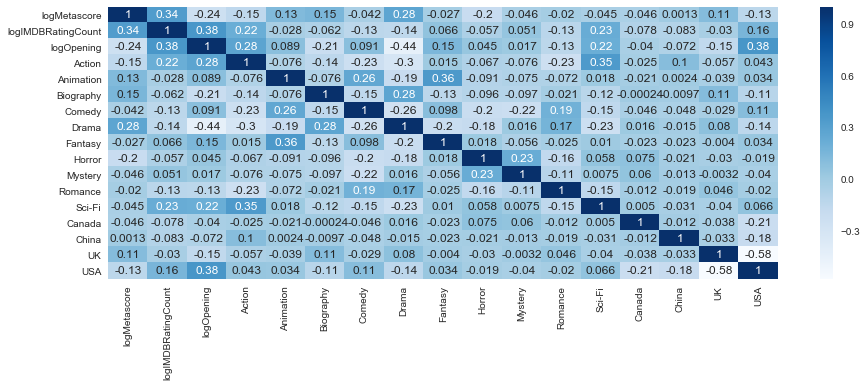

In [137]:
plt.subplots(figsize=(15, 5))
sns.heatmap(smXs.corr(), annot=True, cmap='Blues');

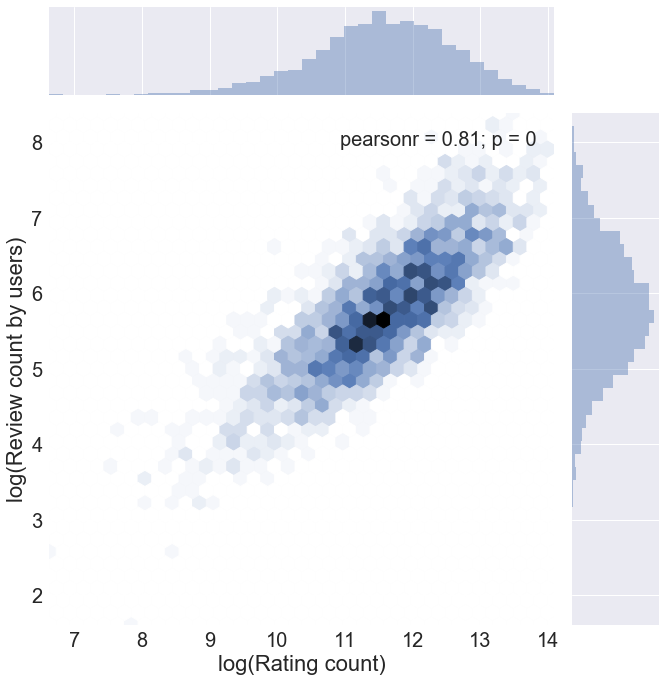

In [138]:
sns.set(font_scale=2)
p = sns.jointplot('logIMDBRatingCount', 'logUserCount', data=X, kind='hex', size=10);
p.set_axis_labels('log(Rating count)', 'log(Review count by users)');
p.savefig('collinear', bbox_inches='tight')

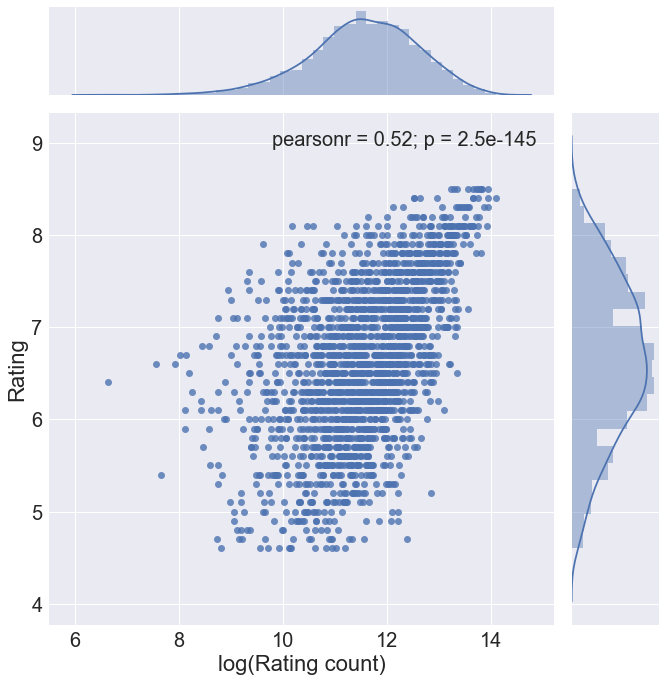

In [139]:
p = sns.jointplot('logIMDBRatingCount', y, data=X, kind='reg', size=10, joint_kws={'fit_reg': False});
p.set_axis_labels('log(Rating count)', 'Rating');
p.savefig('target', bbox_inches='tight')